### import

In [80]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
from IPython.display import Image, display

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image as PILImage

# LLM
from vertexai.generative_models import GenerativeModel, Part, Image as VertexImage
import vertexai

# PDF處理
import PyPDF2

# 設置日誌
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 檢查並創建必要的目錄
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

#

import traceback


### voice to text


In [81]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [82]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [83]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 获取CLIP模型的输出维度
        with torch.no_grad():
            dummy_image = torch.zeros((1, 3, 224, 224))
            image_features = self.clip_model.get_image_features(dummy_image)
            self.image_dimension = image_features.shape[1]  # 应该是 512

        # 设置 Chroma
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"
        )
        
        try:
            # 删除现有的集合
            collections_to_delete = ["questions", "answers", "image_documents"]
            for collection_name in collections_to_delete:
                try:
                    self.chroma_client.delete_collection(collection_name)
                    logger.info(f"Deleted collection: {collection_name}")
                except Exception as e:
                    # pass
                    logger.info(f"Collection {collection_name} does not exist or could not be deleted: {str(e)}")
            
            # 创建新的集合
            # 创建新的集合，指定维度
            sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='all-mpnet-base-v2'
            )

            self.question_collection = self.chroma_client.create_collection(
                name="questions",
                embedding_function=sentence_transformer_ef
            )
            
            self.answer_collection = self.chroma_client.create_collection(
                name="answers",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents",
                metadata={"dimension": self.image_dimension}
            )
            logger.info(f"Created collections with image dimension: {self.image_dimension}")

            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_qa_id": f"q_{i}" if i < len(questions) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    # def search(self, query: str, k: int = 3) -> Dict:
    #     """整合社群和专业知识的搜索方法"""
    #     try:
    #         logger.info("Starting search operation...")
            
    #         # 1. 搜索社群问答
    #         social_results = self.question_collection.query(
    #             query_texts=[query],
    #             n_results=k
    #         )
            
    #         # 2. 搜索专业文献
    #         professional_results = self.answer_collection.query(
    #             query_texts=[query],
    #             n_results=k
    #         )
            
    #         # 3. 整合结果并标记来源
    #         combined_results = {
    #             "social": {
    #                 "questions": social_results["documents"][0] if social_results["documents"] else [],
    #                 "answers": social_results["answers"] if "answers" in social_results else [],
    #                 "metadata": social_results["metadatas"][0] if social_results["metadatas"] else [],
    #                 "relevance": social_results["distances"][0] if social_results["distances"] else []
    #             },
    #             "professional": {
    #                 "content": professional_results["documents"][0] if professional_results["documents"] else [],
    #                 "metadata": professional_results["metadatas"][0] if professional_results["metadatas"] else [],
    #                 "relevance": professional_results["distances"][0] if professional_results["distances"] else []
    #             }
    #         }
            
    #         # 4. 搜索相关图片
    #         image_results = self._search_images(query, k)
    #         combined_results["images"] = image_results

    #         return combined_results
                
    #     except Exception as e:
    #         logger.error(f"Search error: {str(e)}")
    #         return {
    #             "social": {"questions": [], "answers": [], "metadata": [], "relevance": []},
    #             "professional": {"content": [], "metadata": [], "relevance": []},
    #             "images": {"metadata": [], "paths": [], "relevance": []}
    #         }

    def search(self, query: str, k: int = 3) -> Dict:
        """整合社群和專業知識的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 1. 搜索社群問答
            social_results = self.question_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 2. 搜索專業文獻
            professional_results = self.answer_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 3. 整合結果並標記來源
            combined_results = {
                "social": {
                    "questions": [],  # 將重新組織為包含完整資訊的列表
                    "answers": social_results.get("answers", []),
                    "metadata": [],
                    "relevance": social_results["distances"][0] if social_results["distances"] else []
                },
                "professional": {
                    "content": professional_results["documents"][0] if professional_results["documents"] else [],
                    "metadata": professional_results["metadatas"][0] if professional_results["metadatas"] else [],
                    "relevance": professional_results["distances"][0] if professional_results["distances"] else []
                }
            }

            # 處理社群資料，整合問題和連結
            if social_results["documents"] and social_results["metadatas"]:
                questions = social_results["documents"][0]
                metadatas = social_results["metadatas"][0]
                
                for q, meta in zip(questions, metadatas):
                    # 處理每個問題和其對應的metadata
                    question_data = {
                        "content": q,
                        "link": meta.get("link", ""),  # 確保包含連結
                        "source": meta.get("source", ""),
                        "type": meta.get("type", ""),
                        "answer_count": meta.get("answer_count", 0),
                        "images": meta.get("images", "")
                    }
                    combined_results["social"]["questions"].append(question_data)
                    combined_results["social"]["metadata"].append(meta)
                    
                    logger.debug(f"Processed question data: {question_data}")

            # 4. 搜索相關圖片
            image_results = self._search_images(query, k)
            combined_results["images"] = image_results

            logger.info(f"Search completed. Found {len(combined_results['social']['questions'])} social results and {len(combined_results['professional']['content'])} professional results")
            
            return combined_results

        except Exception as e:
            logger.error(f"Error in search: {str(e)}", exc_info=True)
            raise
    
    def _search_images(self, query: str, k: int = 3) -> Dict:
        """Search for relevant images"""
        try:
            # Use the image collection to search for similar images
            image_results = self.image_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            return {
                "metadata": image_results.get("metadatas", []),
                "paths": image_results.get("ids", []),
                "relevance": image_results.get("distances", [])
            }
        except Exception as e:
            logger.error(f"Error searching images: {str(e)}")
            return {
                "metadata": [],
                "paths": [],
                "relevance": []
            }

### 資料處理模組

In [84]:
class DataProcessor:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'link': current_link,
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses)
                        }
                    }
                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最后一个问答对
        if current_post is not None:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'link': current_link,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses)
                }
            }
            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    def is_title_line(line: str) -> bool:
        """检查是否是标题行"""
        # 清理空白
        line = line.strip()
        if not line:
            return False
            
        # 标题的特征
        is_likely_title = (
            # 全大写或首字母大写
            line.isupper() or line.istitle() or
            # 常见的章节名称
            any(keyword in line.lower() for keyword in [
                'abstract', 'introduction', 'method', 'result', 
                'discussion', 'conclusion', 'reference'
            ]) and
            # 长度适中
            5 < len(line) < 100
        )
        
        return is_likely_title
    
    def clean_title(title: str) -> str:
        """清理并标准化标题文本"""
        # 移除数字和特殊字符
        title = ''.join(c for c in title if c.isalpha() or c.isspace())
        # 清理空白
        title = ' '.join(title.split())
        return title
    
    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """处理单个 PDF 文件"""
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 处理每个段落
                    for para in paragraphs:
                        qa_pair = {
                            'question': para[:50] + "...",  # 暂时用段落开头作为问题标识
                            'answers': [para],
                            'metadata': {
                                'type': 'professional',
                                'source_file': pdf_name,  # 添加文件名
                                'page': str(page_num + 1),
                                'content_length': str(len(para))
                            }
                        }
                        professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """处理所有数据：社群数据和多个 PDF"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path("image") / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并所有数据
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 准备数据存储
            questions = []
            answers = []
            question_metadatas = []
            answer_metadatas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                questions.append(qa_pair['question'])
                question_metadatas.append(qa_pair['metadata'])
                
                # 添加该问题的所有回答
                answers.extend(qa_pair['answers'])
                # 为每个回答创建对应的元数据
                for _ in qa_pair['answers']:
                    answer_metadata = qa_pair['metadata'].copy()
                    answer_metadata['parent_question'] = qa_pair['question']
                    answer_metadatas.append(answer_metadata)
            
            # 5. 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 6. 添加到 Chroma
            self.embedding_processor.add_qa_pairs(
                questions=questions,
                answers=answers,
                question_metadatas=question_metadatas,
                answer_metadatas=answer_metadatas,
                images=valid_images
            )
            
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise



### QA系統模組

##### prompt

In [85]:
role = """
You are a professional veterinarian specializing in:

Diagnosis and care of Canine Cognitive Dysfunction Syndrome (CCD)
Pet behavior problem diagnosis and improvement suggestions
"""

In [86]:
task = """
[Overall Instruction]
您將獲得一些參考資料（來自專業paper(.PDF) 和 社群的貼文與留言）。
請總結或解釋相關資訊，並在該內容後方以括號的格式提供來源連結或文件引用，例如：'可以在食物中添加xxx和xxx。[來源: {doc.metadata['link']}]'。
如果多個參考文獻的內容相似，請以PDF的觀點為主並將它們統一為一個簡潔的解釋。
"""

# [Answer content]
# 在你的回答中，考量這些點，包含但不限於：
# 1. 症狀/問題分析
# 2. 專業建議
# 3. 社群經驗中得出的結論
# 4. 醫療提醒

# [Constraints]
# - 不重複相同的摘錄。
# - 使用簡潔且完整的內容並確保總長度< 600字。
# - 若有參考'參考資料'中的內容，在該內容的後面附上連結
# - 對於任何建議，若有衝突以專業資訊為主，社群為補充

# [Step by Step]
# 1. 理解用戶問題。
# 2. 判斷該問題是否需要圖片回答，並給予所需圖片，如果回答需要圖像，請描述圖像內容，與文本一同連貫的說明，例如：'環境的佈置如圖','如圖片中右下角的xx'等
# 3. 總結從向量儲存中檢索到的文字。
# 4. 配合參考資料與你的理解，依照上述內容提供簡短且連貫的答案。
# 5. 僅提及參考內容的標題/鏈接，請勿貼上大文本，也不要貼上你自己找的連結。


# 最後，以同理心和專業的語氣模仿真人回應。

# """


##### code

In [87]:
class QASystem:
    def __init__(self,
                 embedding_processor: HybridEmbeddingProcessor,
                 project_id: str,
                 location: str = "us-central1",
                 model_name: str = 'gemini-1.0-pro-vision-001'):
        self.embedding_processor = embedding_processor
        self.project_id = project_id
        self.location = location
        self.model_name = model_name
        self.init_llm()
        
    def init_llm(self):
        """初始化 Gemini (或改名為 init_model, 和 Llama 版本對齊)"""
        vertexai.init(project=self.project_id, location=self.location)
        self.llm = GenerativeModel(self.model_name)
        logger.info(f"Initialized QA System with Gemini model: {self.model_name}")

    def determine_question_type(self, query: str) -> str:
        """判斷問題類型"""
        # 1. 選擇題：包含 A.B.C.D 或選項相關詞
        if any(char in query for char in ['A.', 'B.', 'C.', 'D.']) or any(keyword in query for keyword in ['何者', '下列', '哪一個', '哪種']):
            return "multiple_choice"
        
        # 2. 是非題：包含「是否」、「是嗎」等
        elif any(keyword in query for keyword in ['是否', '是嗎', '對嗎', '正確嗎']):
            return "true_false"
        
        # 3. 一般諮詢
        else:
            return "qa"

    def get_prompt_by_type(self, query: str, context: str, question_type: str) -> str:
        """根據問題類型返回對應的prompt"""
        
        base_system = role #"System: 您是一位專精於犬類認知功能障礙症候群(CCD)的獸醫師。"
        
        prompts = {
            "multiple_choice": f"""
        {base_system}{task}

        Input Context:
        [Professional Knowledge]: {context}

        Question: {query}

        Task:
        1. 分析每個選項
        2. 指出正確答案
        3. 提供簡短說明

        Output Format:
        請以下列格式回答：
        1. 先指出答案（例：「答案是A」）
        2. 再話解釋原因，並標註來源 [PDF: title] 或 [Experience: link]

        注意：
        - 保持簡潔，總字數不超過150字
        - 使用客觀專業的語氣""",

                "true_false": f"""{base_system}{task}

        Input Context:
        [Professional Knowledge]: {context}

        Question: {query}

        Task:
        1. 評估陳述的正確性
        2. 提供專業解釋

        Output Format:
        請以下列格式回答：
        1. 明確指出「是」或「否」，並提供解釋
        2. 用2-3句話說明原因，並引用來源 [PDF: title] 或 [Experience: link]

        注意：
        - 總字數不超過200字
        - 保持專業客觀""",

                "qa": f"""{base_system}{task}

        Input Context:
        [Professional Knowledge]: {context}
        [Available Images]: 相關圖片資源

        Question: {query}

        Task:
        1. 提供專業解答
        2. 給出具體建議
        3. 分享實用經驗

        Output Format:
        - 先簡短回應飼主的問題，再提供詳細解釋
        - 提供具體建議，並標註來源 [PDF: title]
        - 分享相關照護經驗 [Experience: link]
        - 若有圖片，適時在文字中說明

        注意：
        - 使用平易近人的語言
        - 總字數不超過400字
        - 保持溫和專業的語氣"""
        }
        
        return prompts.get(question_type, prompts["qa"])

    def generate_response(self, query: str) -> Tuple[str, List[VertexImage]]:
        try:
            search_results = self.embedding_processor.search(query)
            context = self.format_context_like_llama(search_results)

            question_type = self.determine_question_type(query)
            prompt = self.get_prompt_by_type(query, context, question_type)

            contents = [prompt]
            vertex_images = []

            # 如果你想加上 Llama 版本檢查圖片的流程，可以像這樣：
            if (search_results.get("social") 
                and search_results["social"].get("metadata")):
                for meta in search_results["social"]["metadata"]:
                    if meta.get("images"):
                        for img in meta["images"].split(","):
                            img_path = self.embedding_processor.image_dir / img
                            if img_path.exists():
                                 # 用 Gemini 方式載入圖片
                                    image = VertexImage.load_from_file(str(img_path))
                                    contents.append(image)
                                    vertex_images.append(image)
                                    # 假設只要一張圖片就 break
                                    break
                                   
                        # 如果只要一張圖片就 break
                        if vertex_images:
                            break

            logger.info(f"Generating response with {len(contents)} contents in Gemini")

            # 呼叫 Gemini LLM
            response = self.llm.generate_content(contents)
            return response.text, vertex_images

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}", exc_info=True)
            return f"抱歉，系統處理您的問題時發生錯誤: {str(e)}", []

    def format_context_like_llama_old(self, search_results: Dict) -> str:
        logger.info("=== Starting context formatting ===")
        logger.info(f"Input search_results structure: {json.dumps(search_results, indent=2)}")
        
        try:
            context = ""
            
            # 處理社群討論
            if search_results.get("social"):
                logger.info("Processing social data...")
                context += "\n[社群討論]\n"
                social_data = search_results["social"]
                logger.info(f"Social data content: {json.dumps(social_data, indent=2)}")
                
                # 處理討論內容和連結
                if "documents" in social_data:
                    for i, doc in enumerate(social_data["documents"]):
                        logger.info(f"Processing social document {i + 1}")
                        content = doc.get("content", "")
                        link = doc.get("link", "")
                        logger.info(f"Document content: {content}")
                        logger.info(f"Document link: {link}")
                        
                        if link and link.startswith("https:"):
                            context += f"{content} [Experience: {link}]\n\n"
                            logger.info(f"Added social content with link: {link}")
                        else:
                            context += f"{content}\n\n"
                            logger.info("Added social content without link")

            # 處理專業文獻
            if search_results.get("professional"):
                logger.info("Processing professional data...")
                context += "\n[專業參考]\n"
                prof_data = search_results["professional"]
                logger.info(f"Professional data content: {json.dumps(prof_data, indent=2)}")
                
                if "documents" in prof_data:
                    for i, doc in enumerate(prof_data["documents"]):
                        logger.info(f"Processing professional document {i + 1}")
                        content = doc.get("content", "")
                        title = doc.get("title", "Unknown Source")
                        logger.info(f"Document content: {content}")
                        logger.info(f"Document title: {title}")
                        
                        context += f"{content} [PDF: {title}]\n\n"
                        logger.info(f"Added professional content with title: {title}")

            logger.info("=== Final formatted context ===")
            logger.info(context)
            
            return context.strip() if context.strip() else "未找到相關信息"
            
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}", exc_info=True)
            logger.error(traceback.format_exc())
            return "處理參考資料時發生錯誤"
    
    def format_context_like_llama(self, search_results: Dict) -> str:
        try:
            context = ""
            if search_results.get("social"):
                context += "\n[社群討論]\n"
                question_s = search_results["social"].get("link", [])
                metadata_s = search_results["social"].get("metadata", [])
                for q, meta in zip(question_s, metadata_s):
                    context += f"標題：{q}\n"
                    if "link" in meta:
                        context += f"link: {meta['Link']}\n\n"

            if search_results.get("professional"):
                context += "\n[專業文獻]\n"
                c_p = search_results["professional"].get("content", [])
                metadata_p = search_results["social"].get("metadata", [])
                for cp,mp in zip(c_p,metadata_p):
                    context += f"{cp}\n\n"
                    if "source_file" in mp:
                        context += f"title: {meta['source_file']}\n\n"
                    

            return context if context.strip() else "未找到相關信息"

        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "無法取得參考資料"
        
    def display_response(self, query: str):
        try:
            logger.info("Starting to generate response...")
            response_text, images = self.generate_response(query)
            
            print("問題：", query)
            print("\n系統的回答：")
            print(response_text)
            print("\n" + "-"*50 + "\n")

            logger.info(f"Response generated. Number of images: {len(images)}")
            if images:
                print("\n相關圖片：")
                for i, img in enumerate(images, 1):
                    logger.info(f"Displaying image {i}")
                    # 在 Jupyter 環境中顯示 VertexImage
                    try:
                        display(img)
                    except Exception as e:
                        logger.error(f"Error displaying image {i}: {str(e)}")
            else:
                logger.info("No images to display")
                
        except Exception as e:
            logger.error(f"Error in display_response: {str(e)}", exc_info=True)


### 系統初始化和資料處理

In [88]:
# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

pdf_paths = [
    "RAG_data/01.pdf",
    "RAG_data/02.pdf",
    "RAG_data/03.pdf"
]

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_paths=pdf_paths
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
python(16688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:__main__:Deleted collection: questions
INFO:__main__:Deleted collection: answers
INFO:__main__:Deleted collection: image_documents
INFO:__main__:Created collections with image dimension: 512
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg f

### 系統測試

In [96]:
# 初始化 QA 系統
qa_system = QASystem(
    embedding_processor=embedding_processor,
    project_id="high-tribute-438514-j7",  
    location="us-central1"
)

INFO:__main__:Initialized QA System with Gemini model: gemini-1.0-pro-vision-001


#### 用語音轉文字做輸入

In [90]:
# audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
# transcription = transcribe_file(audio_file)
# qa_system.display_response(transcription)

#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:__main__:Search completed. Found 3 social results and 3 professional results
INFO:__main__:Generating response with 2 contents in Gemini
INFO:__main__:Response generated. Number of images: 1
INFO:__main__:Displaying image 1


問題： 哪種犬容易失智？

系統的回答：
 1. 答案是：小型犬
2. 小型犬容易失智，因為小型犬的腦部較小，神經元密度較高，更容易受到氧化壓力和炎症的影響。[PDF: Canine Cognitive Dysfunction]

--------------------------------------------------


相關圖片：


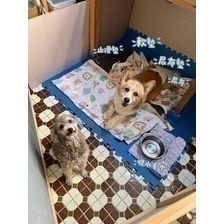

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 28.92it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:__main__:Search completed. Found 3 social results and 3 professional results
INFO:__main__:Generating response with 2 contents in Gemini
INFO:__main__:Response generated. Number of images: 1
INFO:__main__:Displaying image 1


問題： 大中小型狗的失智照顧方式有什麼不同？

系統的回答：
 狗狗失智症狀照顧方式沒有太大差異，但有些事項需要注意。小型犬可能會更容易焦慮不安，中大型犬可能會更有破壞力。

您可以採取以下措施來幫助狗狗應對認知功能障礙：

- 確保狗狗有足夠的運動和精神刺激。這可以幫助牠們保持活躍和健康。[PDF: Canine Cognitive Dysfunction]
- 餵食狗狗富含抗氧化劑的食物。抗氧化劑可以幫助保護大腦免受損害。[PDF: Canine Cognitive Dysfunction]
- 確保狗狗有舒適的睡眠環境。這可以幫助牠們在夜間得到充足的休息。[PDF: Canine Cognitive Dysfunction]
- 帶狗狗去看獸醫進行定期檢查。這可以幫助您及早發現任何健康問題。[PDF: Canine Cognitive Dysfunction]

如果您有任何其他問題，請隨時聯繫我。

--------------------------------------------------


相關圖片：


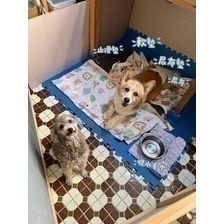

In [99]:
# 測試查詢
test_queries = [
    # "在評估老年犬認知功能時，β-澱粉樣蛋白(β-amyloid)與人類阿茲海默症患者的差異為何?這些差異對臨床治療方案的選擇有何影響？請說明其分子機制。",
    # "請詳細解釋老年犬腦部 MRI 中 interthalamic adhesion thickness 與認知功能的關聯性。根據研究,什麼樣的數值會被認為是認知功能障礙的臨床指標？",
    # "根據社群經驗分享,夜間躁動是失智犬常見的問題之一。從生理機制、環境調整和藥物介入三個層面,應該如何全方位地改善這個問題？",
    # "有飼主分享老犬會在熟悉的散步路線上突然停下或迷路,從神經科學角度來看,這與大腦哪些區域的退化有關?應該如何根據退化程度調整運動模式？",
    # "目前研究指出中鏈脂肪酸(MCT)對改善老年犬認知功能有潛在效果,請比較市面上常見的MCT補充來源(如椰子油vs. MCT油)的優缺點,並說明劑量建議。",
    # "如何建立一個老年犬的生活品質評估系統？請從日常行為、認知功能、情緒狀態等面向設計具體的評分指標,並說明如何根據評分調整照護方案。",
    # "Selegiline(愛乃脂)常被用於治療犬類認知功能障礙,但研究顯示效果有限。請分析其作用機制的侷限性,以及是否有新型藥物可以克服這些限制？",
    # "失智犬照護中,「環境豐富化」(Environmental enrichment)扮演重要角色。請根據研究和實務經驗,設計一套針對不同嚴重程度失智犬的環境豐富化方案。"
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向"
# "問題一：根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
# "問題二：資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
# "問題三：在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
# "問題四：資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
# "問題五：針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。
"哪種犬容易失智？","大中小型狗的失智照顧方式有什麼不同？"
                    ]

for query in test_queries:
    qa_system.display_response(query)


### 互動式查詢介面

In [92]:
# from IPython.display import clear_output

# def interactive_query():
#     while True:
#         query = input("請輸入您的問題 (輸入'quit'結束): ").strip()
        
#         if query.lower() == 'quit':
#             break
            
#         clear_output(wait=True)
#         qa_system.display_response(query)
#         print("\n輸入新的問題或輸入'quit'結束")

# # 啟動互動式查詢
# interactive_query()